In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image

In [214]:
path = os.path.join("C:\\Users\\Robin\\Desktop\\deep_learning\\MineRLNavigateDense-v0\\v3_absolute_grape_changeling-12_2293-4124")

def process_frames():
    vid = np.load(path+"\\NDTRAIN.npy", allow_pickle=True)
    print(vid[0].shape)
    number_of_frames = vid[0].shape[0]/12288
    vid_imgs = vid[0].reshape([int(number_of_frames), 64, 64, 3])
    vid_imgs = np.array(vid_imgs[-1794:][:]).astype(np.uint8)
    print(vid_imgs.shape)
    processed = vid_imgs.reshape(1794, 64, 64, 3)
    processed = processed[:-1]
    test = processed[-1]

    test = test.reshape(-1,64,64,3)
    
    return test, processed

process_frames()

(22511616,)
(1794, 64, 64, 3)


(array([[[[ 12,  23,  12],
          [ 20,  31,  20],
          [ 21,  29,  19],
          ...,
          [ 20,  31,  20],
          [ 20,  31,  20],
          [ 17,  28,  17]],
 
         [[ 18,  29,  18],
          [ 13,  24,  13],
          [ 19,  27,  17],
          ...,
          [ 16,  27,  16],
          [ 19,  30,  19],
          [  9,  20,   9]],
 
         [[ 20,  31,  20],
          [ 16,  27,  16],
          [ 14,  22,  12],
          ...,
          [ 17,  28,  17],
          [ 18,  29,  16],
          [ 20,  31,  18]],
 
         ...,
 
         [[ 79,  56,  41],
          [ 79,  56,  41],
          [ 78,  56,  38],
          ...,
          [110,  77,  52],
          [161, 122,  92],
          [137,  98,  68]],
 
         [[ 79,  57,  39],
          [ 78,  56,  38],
          [ 75,  54,  39],
          ...,
          [107,  78,  56],
          [120,  75,  40],
          [167, 122,  87]],
 
         [[ 78,  56,  38],
          [ 77,  55,  37],
          [ 75,  54,  39],
   

In [244]:
data = np.load(path+"\\rendered.npz")

print("available data keys: \n")
for x in data.keys():
    print(x)
print("\n")

def state_observations():
    state_obs = [data[x] for x in data.keys()]
    state_obs[1] = state_obs[1][:1792]
    state_obs[2] = state_obs[2][:1792]
    camera_x = np.array([x[0] for x in state_obs[11]])/180.
    camera_y = np.array([x[1] for x in state_obs[11]])/180.
    place = state_obs[-1]
    state_obs = state_obs[:11]
    state_obs.append(camera_x)
    state_obs.append(camera_y)
    state_obs.append(place)
    state_obs = state_obs[3:]
    
    for i in range(len(state_obs[-1])):
        if state_obs[-1][i] == "none":
            state_obs[-1][i] = 0
        else:
            state_obs[-1][i] = 1
    
    actions = []
    for i in range(1792):
        action_cluster = []
        for x in range(11):
            action_cluster.append(state_obs[x][i])
        actions.append(action_cluster)
        
    print(np.array(actions).shape)
    
    return actions

actions = np.array(state_observations()).astype(np.float32)
print(actions)

available data keys: 

reward
observation$compassAngle
observation$inventory$dirt
action$forward
action$left
action$back
action$right
action$jump
action$sneak
action$sprint
action$attack
action$camera
action$place


(1792, 11)
[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 1.          0.          0.         ... -0.          0.00166668
   0.        ]
 [ 1.          0.          0.         ... -0.00166666  0.00499997
   0.        ]
 ...
 [ 1.          1.          0.         ...  0.          0.
   0.        ]
 [ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 1.          0.          0.         ...  0.          0.
   0.        ]]


In [245]:
action_model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[64, 64, 2]),
    keras.layers.Conv2D(32, kernel_size=3),
    keras.layers.Flatten(),
    keras.layers.Dense(11, activation="sigmoid")
])

action_model.compile(loss="binary_crossentropy", optimizer="Adam")

batch_size = 1

def train_model(model, n_epochs=5):
    for epoch in range(n_epochs):
        
        print(epoch)
        batch = np.random.choice(1792, batch_size)
        
        print("SHAPE",process_frames()[1].shape)
        img_a = np.array(Image.fromarray(process_frames()[1][batch].reshape(64,64,3), "RGB").convert("L"))
        print(img_a)
        img_b = np.array(Image.fromarray(process_frames()[1][batch+1].reshape(64,64,3), "RGB").convert("L"))
        stacked = np.stack([img_a, img_b], axis=2).reshape(1, 64, 64, 2)
      
        
        model.train_on_batch(stacked, tf.cast(np.array(actions)[batch], tf.float32))
        
train_model(action_model)

0
(22511616,)
(1794, 64, 64, 3)
SHAPE (1793, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
[[169 169 167 ...  38  35  18]
 [169 169 169 ...  38  18   1]
 [169 169 169 ...   2   1   1]
 ...
 [  0  22  21 ...  57  58  43]
 [ 22  12  12 ...  87  58  58]
 [ 42  12   1 ...  86  88  58]]
(22511616,)
(1794, 64, 64, 3)
1
(22511616,)
(1794, 64, 64, 3)
SHAPE (1793, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
[[  1   1  32 ...  23  19  19]
 [ 32  32   1 ...   8  30  38]
 [ 16   1  32 ...  30  38  32]
 ...
 [ 90  74 104 ...  81  81  88]
 [ 73 102 103 ...  79  81  86]
 [102 103 100 ...  80  79 115]]
(22511616,)
(1794, 64, 64, 3)
2
(22511616,)
(1794, 64, 64, 3)
SHAPE (1793, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
[[ 92  92  58 ... 196 195 195]
 [ 58  73  90 ... 196 195 182]
 [ 74  73  72 ... 196 183 183]
 ...
 [ 70 108 107 ...  67  68  68]
 [ 70  68  86 ...  39  68  68]
 [ 70  86  86 ...  83  84  68]]
(22511616,)
(1794, 64, 64, 3)
3
(22511616,)
(1794, 64, 64, 3)
SHAPE (1793, 64, 64, 3)
(22511616,)
(1794, 6

1173
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


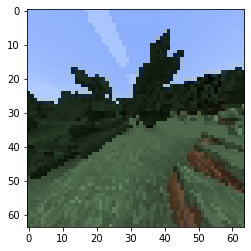

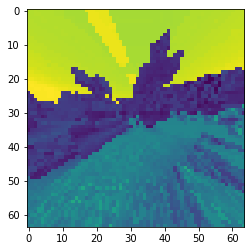

(22511616,)
(1794, 64, 64, 3)


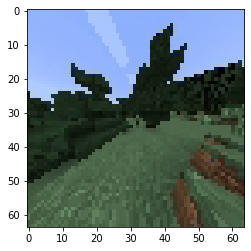

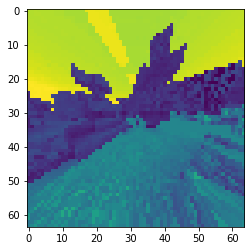

1/1 [==============================] - 0s 4ms/step - loss: 165.9818
165.98175048828125
[[1.00000000e+00 0.00000000e+00 1.14132045e-32 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
1684
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


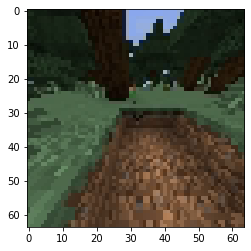

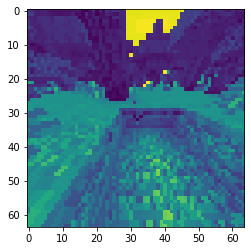

(22511616,)
(1794, 64, 64, 3)


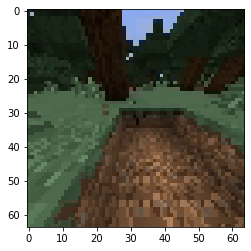

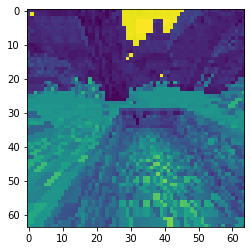

1/1 [==============================] - 0s 3ms/step - loss: 177.0358
177.03582763671875
[[1.0000000e+00 0.0000000e+00 6.5347830e-13 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3285561e-21
  0.0000000e+00]]
[ 0.          0.          0.          0.          0.          0.
  0.          1.         -0.          0.00499997  0.        ]
582
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


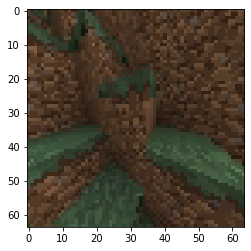

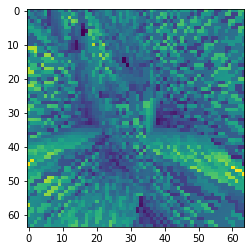

(22511616,)
(1794, 64, 64, 3)


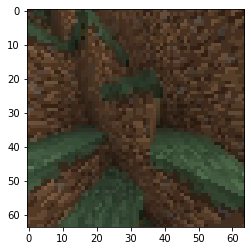

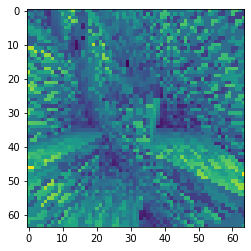

1/1 [==============================] - 0s 6ms/step - loss: 60.4282
60.42822265625
[[1.0000000e+00 0.0000000e+00 1.1077259e-17 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.7437398e-24
  0.0000000e+00]]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
581
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


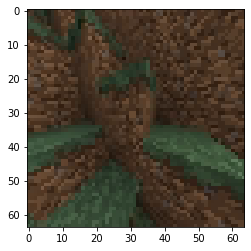

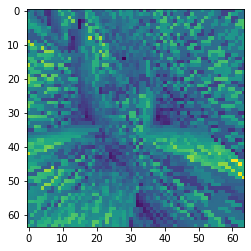

(22511616,)
(1794, 64, 64, 3)


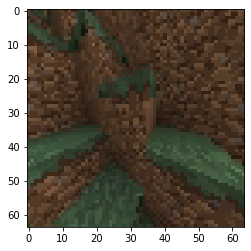

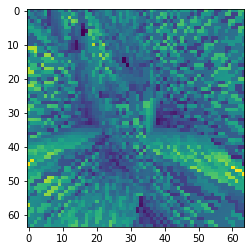

1/1 [==============================] - 0s 6ms/step - loss: 60.5973
60.5972785949707
[[1.0000000e+00 0.0000000e+00 1.2470143e-16 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.5858674e-26
  0.0000000e+00]]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
129
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


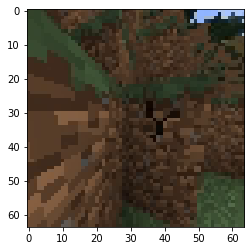

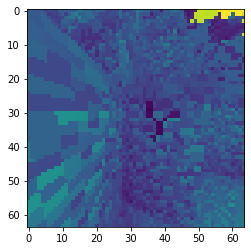

(22511616,)
(1794, 64, 64, 3)


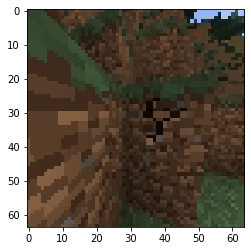

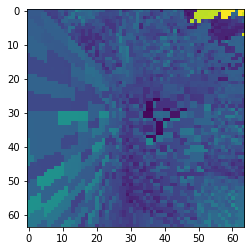

1/1 [==============================] - 0s 7ms/step - loss: 160.3456
160.34556579589844
[[1.0000000e+00 0.0000000e+00 2.9372408e-19 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.4077876e-20
  0.0000000e+00]]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
 -8.3333388e-04  1.6666836e-03  0.0000000e+00]
1668
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


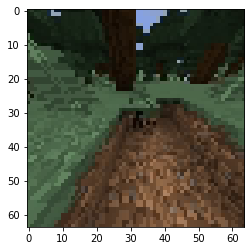

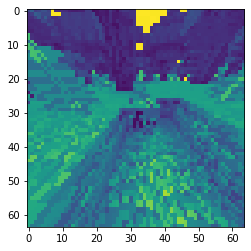

(22511616,)
(1794, 64, 64, 3)


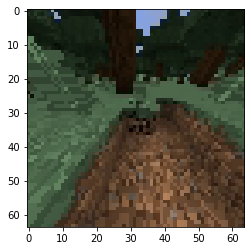

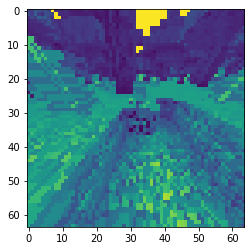

1/1 [==============================] - 0s 3ms/step - loss: 176.3672
176.36724853515625
[[1.000000e+00 0.000000e+00 1.565563e-16 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.683979e-31
  0.000000e+00]]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
1757
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


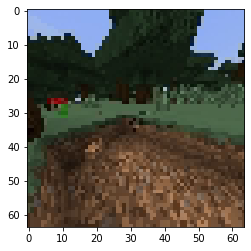

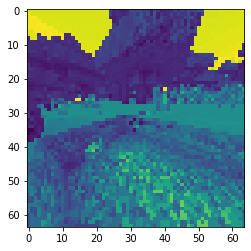

(22511616,)
(1794, 64, 64, 3)


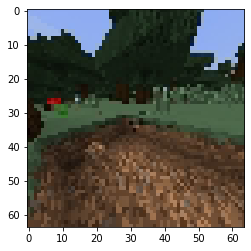

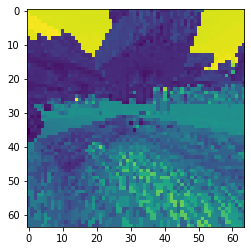

1/1 [==============================] - 0s 3ms/step - loss: 193.1031
193.1030731201172
[[1.0000000e+00 0.0000000e+00 2.6908175e-23 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.4014285e-31
  0.0000000e+00]]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
1017
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


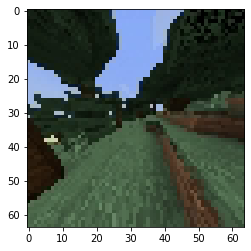

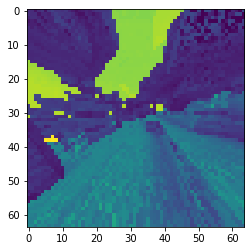

(22511616,)
(1794, 64, 64, 3)


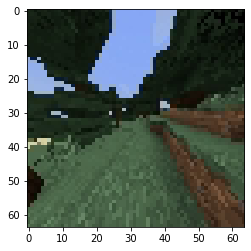

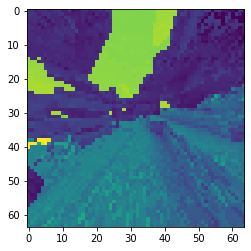

1/1 [==============================] - 0s 2ms/step - loss: 182.3318
182.33175659179688
[[1.0000000e+00 0.0000000e+00 1.7857842e-21 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2166169e-17
  0.0000000e+00]]
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
1336
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


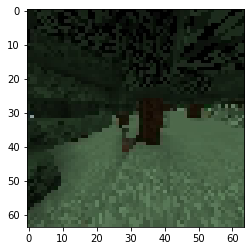

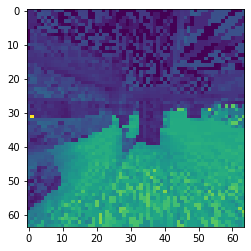

(22511616,)
(1794, 64, 64, 3)


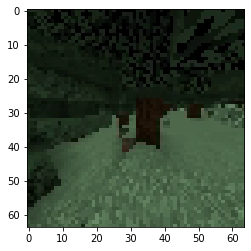

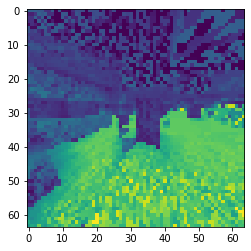

1/1 [==============================] - 0s 4ms/step - loss: 133.9578
133.95779418945312
[[1.0000000e+00 0.0000000e+00 5.5944678e-05 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7115468e-26
  0.0000000e+00]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1788
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


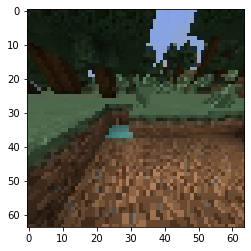

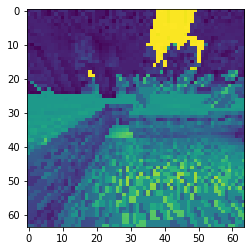

(22511616,)
(1794, 64, 64, 3)


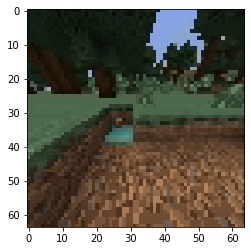

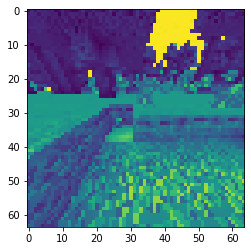

1/1 [==============================] - 0s 2ms/step - loss: 70.3247
70.3247299194336
[[1.0000000e+00 0.0000000e+00 1.5090544e-16 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1009515e-25
  0.0000000e+00]]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [247]:
for x in range(10):    
    random_index = np.random.choice(1792)
    print(random_index)
    test_a = Image.fromarray(process_frames()[1][random_index], "RGB").convert("L")
    test_b = Image.fromarray(process_frames()[1][random_index+1], "RGB").convert("L")

    plt.imshow(process_frames()[1][random_index])
    plt.show()

    plt.imshow(test_a)
    plt.show()

    plt.imshow(process_frames()[1][random_index+1])
    plt.show()

    plt.imshow(test_b)
    plt.show()

    stacked = np.stack([test_a, test_b]).reshape(1,64,64,2)
    print(action_model.evaluate(stacked, np.array(actions)[random_index].reshape(1, 11)))

    print(action_model.predict(stacked))
    print(np.array(actions)[random_index])